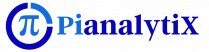

# Face Swap

In this project, we will be using opencv and dlib to extract faces of human-beings from a given image. We will use a pretrained model to extract landmarks from the faces.

In [ ]:
# Library imports
import cv2
import numpy as np
import dlib
import requests  
from PIL import Image

We will start by importing some required libraries.

In [ ]:
# Downloading shape_predictor
!wget 'https://github.com/tzutalin/dlib-android/raw/master/data/shape_predictor_68_face_landmarks.dat'

Now we will download pretrained model shape_predictor from github into our google collab.

In [ ]:
# Extracting index from array
def extract_index_nparray(nparray):
    index = None
    for num in nparray[0]:
        index = num
        break
    return index

Now we will create a function to extract the index from the numpy array.

In [ ]:
# Reading source image form url
image1 = Image.open(requests.get('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSx8Pu1tW1uCiZPfj9K1EL6uHxbg3bOKO9XkA&usqp=CAU', stream=True).raw)
image1 = image1.resize((300,300))
image1

Next we will load our source image from the internet using url and resize it.

In [ ]:
# Reading destination image form url
image2 = Image.open(requests.get('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTYX1dyl9INRo5cbvDeTILRcZVzfcMsCsE0kg&usqp=CAU', stream=True).raw)
image2 = image2.resize((300,300))
image2

Here we will load our destination image from the internet using url and resize it.

In [ ]:
# Converting image to array and converting them to grayscale
img = np.array(image1)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mask = np.zeros_like(img_gray)
img2 = np.array(image2)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

Now we will convert our images into numpy array and use cv2 to convert it into grayscale. We will also create empty image or mask similar to our source image with zeros.

In [ ]:
# Initalizing frontal face detector and shape predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
height, width, channels = img2.shape
img2_new_face = np.zeros((height, width, channels), np.uint8)

Here we will first load Face detector and Face landmarks predictor using dlib and then we will find the height, width, channels which are required for creating empty image with zeros.

In [ ]:
# Face 1
faces = detector(img_gray)
for face in faces:
    landmarks = predictor(img_gray, face)
    landmarks_points = []
    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmarks_points.append((x, y))

    points = np.array(landmarks_points, np.int32)
    convexhull = cv2.convexHull(points)
    cv2.fillConvexPoly(mask, convexhull, 255)

    face_image_1 = cv2.bitwise_and(img, img, mask=mask)

    # Delaunay triangulation
    rect = cv2.boundingRect(convexhull)
    subdiv = cv2.Subdiv2D(rect)
    subdiv.insert(landmarks_points)
    triangles = subdiv.getTriangleList()
    triangles = np.array(triangles, dtype=np.int32)

    indexes_triangles = []
    for t in triangles:
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])


        index_pt1 = np.where((points == pt1).all(axis=1))
        index_pt1 = extract_index_nparray(index_pt1)

        index_pt2 = np.where((points == pt2).all(axis=1))
        index_pt2 = extract_index_nparray(index_pt2)

        index_pt3 = np.where((points == pt3).all(axis=1))
        index_pt3 = extract_index_nparray(index_pt3)

        if index_pt1 is not None and index_pt2 is not None and index_pt3 is not None:
            triangle = [index_pt1, index_pt2, index_pt3]
            indexes_triangles.append(triangle)


First we need to pass image to detector then that object will used to extract landmarks using predictor. Then storing extracted landmarks points x and y into landmarks points list. We're going then to segment the face into triangles. This step is the core of our face swapping, as later we will simply exchange each triangle with the correspondent triangle of the destination image.
The triangulation of the destination image needs to have the same patterns of the triangulation of the source image. That means that the connection of the points has to be the same. So after we do the triangulation of the source image, from that triangulation we take the indexes of the landmark points so that we can replicate the same triangulation on the destination image.
Once we have the triangles indexes we loop through them and we triangulate the destination face.

In [ ]:
# Face 2
faces2 = detector(img2_gray)
for face in faces2:
    landmarks = predictor(img2_gray, face)
    landmarks_points2 = []
    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        landmarks_points2.append((x, y))


    points2 = np.array(landmarks_points2, np.int32)
    convexhull2 = cv2.convexHull(points2)


Now we will apply similar function as done for source images to extract landmarks.

In [ ]:
# Creating empty mask
lines_space_mask = np.zeros_like(img_gray)
lines_space_new_face = np.zeros_like(img2)

Here we will create empty images with zeros which will be required for further processing.

In [ ]:
# Triangulation of both faces
for triangle_index in indexes_triangles:
    # Triangulation of the first face
    tr1_pt1 = landmarks_points[triangle_index[0]]
    tr1_pt2 = landmarks_points[triangle_index[1]]
    tr1_pt3 = landmarks_points[triangle_index[2]]
    triangle1 = np.array([tr1_pt1, tr1_pt2, tr1_pt3], np.int32)


    rect1 = cv2.boundingRect(triangle1)
    (x, y, w, h) = rect1
    cropped_triangle = img[y: y + h, x: x + w]
    cropped_tr1_mask = np.zeros((h, w), np.uint8)


    points = np.array([[tr1_pt1[0] - x, tr1_pt1[1] - y],
                       [tr1_pt2[0] - x, tr1_pt2[1] - y],
                       [tr1_pt3[0] - x, tr1_pt3[1] - y]], np.int32)

    cv2.fillConvexPoly(cropped_tr1_mask, points, 255)

    # Lines space
    cv2.line(lines_space_mask, tr1_pt1, tr1_pt2, 255)
    cv2.line(lines_space_mask, tr1_pt2, tr1_pt3, 255)
    cv2.line(lines_space_mask, tr1_pt1, tr1_pt3, 255)
    lines_space = cv2.bitwise_and(img, img, mask=lines_space_mask)

    # Triangulation of second face
    tr2_pt1 = landmarks_points2[triangle_index[0]]
    tr2_pt2 = landmarks_points2[triangle_index[1]]
    tr2_pt3 = landmarks_points2[triangle_index[2]]
    triangle2 = np.array([tr2_pt1, tr2_pt2, tr2_pt3], np.int32)


    rect2 = cv2.boundingRect(triangle2)
    (x, y, w, h) = rect2

    cropped_tr2_mask = np.zeros((h, w), np.uint8)

    points2 = np.array([[tr2_pt1[0] - x, tr2_pt1[1] - y],
                        [tr2_pt2[0] - x, tr2_pt2[1] - y],
                        [tr2_pt3[0] - x, tr2_pt3[1] - y]], np.int32)

    cv2.fillConvexPoly(cropped_tr2_mask, points2, 255)

    # Warp triangles
    points = np.float32(points)
    points2 = np.float32(points2)
    M = cv2.getAffineTransform(points, points2)
    warped_triangle = cv2.warpAffine(cropped_triangle, M, (w, h))
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=cropped_tr2_mask)

    # Reconstructing destination face
    img2_new_face_rect_area = img2_new_face[y: y + h, x: x + w]
    img2_new_face_rect_area_gray = cv2.cvtColor(img2_new_face_rect_area, cv2.COLOR_BGR2GRAY)
    _, mask_triangles_designed = cv2.threshold(img2_new_face_rect_area_gray, 1, 255, cv2.THRESH_BINARY_INV)
    warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask_triangles_designed)

    img2_new_face_rect_area = cv2.add(img2_new_face_rect_area, warped_triangle)
    img2_new_face[y: y + h, x: x + w] = img2_new_face_rect_area


Here we are performing same operations as above for the destination image.
After we have the triangulation of both faces we take the triangles of the source face and we extract them.
We also need to take the coordinates of the triangles of the destination face, so that we can warp the triangles of the source face to have same size and perspective of the matchin triangle on the destination face.

In [ ]:
# Face swapped (putting 1st face into 2nd face)
img2_face_mask = np.zeros_like(img2_gray)
img2_head_mask = cv2.fillConvexPoly(img2_face_mask, convexhull2, 255)
img2_face_mask = cv2.bitwise_not(img2_head_mask)


Once we have cutted and wrapped all the triangles we need to link them together.
We simply rebuild the face using the triangulation pattern, with the only difference that this time we put the wrapped triangle.

In [ ]:
img2_head_noface = cv2.bitwise_and(img2, img2, mask=img2_face_mask)
result = cv2.add(img2_head_noface, img2_new_face)

The face is now ready to be replaced. We cut out the face of the destination image to make space for the new face.

So we take the new face, and the destination image without face and we link them together.

In [ ]:
# Creating seamless clone of two faces
(x, y, w, h) = cv2.boundingRect(convexhull2)
center_face2 = (int((x + x + w) / 2), int((y + y + h) / 2))
seamlessclone = cv2.seamlessClone(result, img2, img2_head_mask, center_face2, cv2.NORMAL_CLONE)

Finally the faces are correctly swapped and it’s time to adjust the colors so that the source image fits the destination image.

On Opencv we have a built in function called “seamlessClone” that does this operation automatically.
We need to take the new face (created on the 6th step), take the original destination image and it’s mask to cut out the face, we need to get the center of the face.

In [ ]:
# Converting array to image
Image.fromarray(seamlessclone)

Finally we will visualize output numpy image by convert it into Image object of Pillow.

# Conclusion

We started with downloading the pretrained model for face landmark and download the images from the internet on which we will work. Next we used CV2 and Dlib for preprocessing the images and used different functionalities to make reach to the end which is swapping the face of destination image with source image.

# Scope

This project can be used for learning and understanding different concepts of computer vision. This project can be use to build Augmented Reality applications like Snapchat, etc.